In [13]:
# Import Dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme()

In [14]:
# Read csv files
project_root = os.path.dirname(os.getcwd())
data_path = os.path.join(project_root, 'data', 'processed')
dataframes = {}

def clean_csvname(filename):
    return filename.replace('.csv', '')

for file in os.listdir(data_path):
    if file.endswith('.csv'):
        name = clean_csvname(file)
        dataframes[name] = pd.read_csv(os.path.join(data_path, file))

In [15]:
dataframes['orders']['date'].max()

'2022-06-29 00:00:00'

In [16]:
# List all dataframes
print(dataframes.keys())
keys = list(dataframes.keys())

dict_keys(['amazon_sales_pdcleaned', 'orders', 'regional_cancelled', 'regional_demand', 'regional_sales', 'sales', 'sales_cancelled', 'top_regions_item_sales', 'weekly_revenue'])


# Sales Analysis

Let's start by inspecting the inventory that generated at least one sale. How many items are there per category?

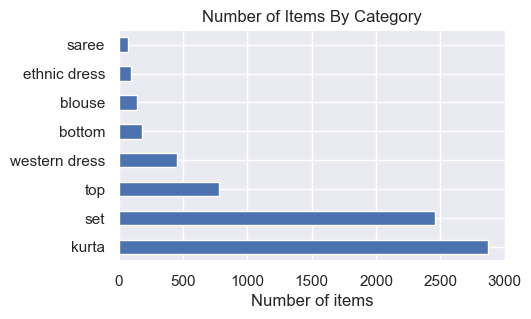

Item Sales Data


,asin,category,total_orders,orders_at_discount,units_sold,median_unit_price,revenue
0,B09SDXFFQ1,western dress,604,588,605,735.0,449852
1,B09SDY8DCT,western dress,510,504,515,735.0,384455
2,B09SDYQ3WG,western dress,462,450,463,735.0,346542
3,B081WSCKPQ,kurta,442,234,445,399.0,181141
4,B08XNJG8B1,set,431,351,432,1112.0,496430


Summary Statistics


,total_orders,orders_at_discount,units_sold,median_unit_price,revenue
mean,15.202634,10.889550,15.257009,613.449094,10081.691872
std,30.031747,22.996456,30.159211,269.330475,22155.705885
min,1.000000,0.000000,1.000000,199.000000,199.000000
25%,3.000000,2.000000,3.000000,412.125000,1305.000000
50%,6.000000,5.000000,6.000000,549.000000,3535.500000
75%,16.000000,11.000000,16.000000,751.000000,9965.750000
max,604.000000,588.000000,605.000000,2598.000000,496430.000000


In [17]:
# Relabel dupatta category (only has 3 items) and show the number of items by category
dataframes['sales']['category'] = dataframes['sales']['category'].replace({'dupatta': 'ethnic dress'})
plt.figure(figsize=(5, 3))
dataframes['sales']['category'].value_counts().plot(kind='barh')
plt.xlabel('Number of items')
plt.ylabel('')
plt.title('Number of Items By Category')
plt.show()

# Display item sales data and summary statistics
print("Item Sales Data")
display(dataframes['sales'].head())

print("Summary Statistics")
display(dataframes['sales'].describe().iloc[1:])

Sales data is highly skewed. We'll do an 80/20 split and analyze topsellers separately

In [18]:
# Split topsellers from sales
dataframes['sales']['top_seller'] = (
    (dataframes['sales']['total_orders'] > dataframes['sales']['total_orders'].quantile(0.8)) |
    (dataframes['sales']['revenue'] > dataframes['sales']['revenue'].quantile(0.8))
    )

topsellers = dataframes['sales'][dataframes['sales']['top_seller']==True]
sales = dataframes['sales'][dataframes['sales']['top_seller']==False]

print(f"Topsellers ({topsellers.shape[0]} items)")
display(topsellers.describe().iloc[1:])

print(f"Regular sales ({sales.shape[0]} items)")
display(sales.describe().iloc[1:])

Topsellers (1628 items)


,total_orders,orders_at_discount,units_sold,median_unit_price,revenue
mean,47.00000,33.462531,47.173833,737.277641,32776.926904
std,50.30414,39.879125,50.530972,300.878213,37850.015226
min,6.00000,4.000000,6.000000,292.000000,5895.000000
25%,22.00000,16.000000,22.000000,499.000000,14870.250000
50%,31.00000,22.000000,31.000000,688.000000,21785.500000
75%,50.00000,36.000000,50.000000,925.000000,35788.000000
max,604.00000,588.000000,605.000000,2598.000000,496430.000000


Regular sales (5434 items)


,total_orders,orders_at_discount,units_sold,median_unit_price,revenue
mean,5.676297,4.126794,5.694884,576.350662,3282.309717
std,4.541475,3.552702,4.558799,247.374175,2891.668160
min,1.000000,0.000000,1.000000,199.000000,199.000000
25%,2.000000,1.000000,2.000000,387.000000,998.000000
50%,4.000000,3.000000,4.000000,518.000000,2300.000000
75%,8.000000,6.000000,8.000000,690.000000,4840.500000
max,19.000000,19.000000,20.000000,2598.000000,12859.000000


## Regular sales analysis

Text(0.5, 0, '')

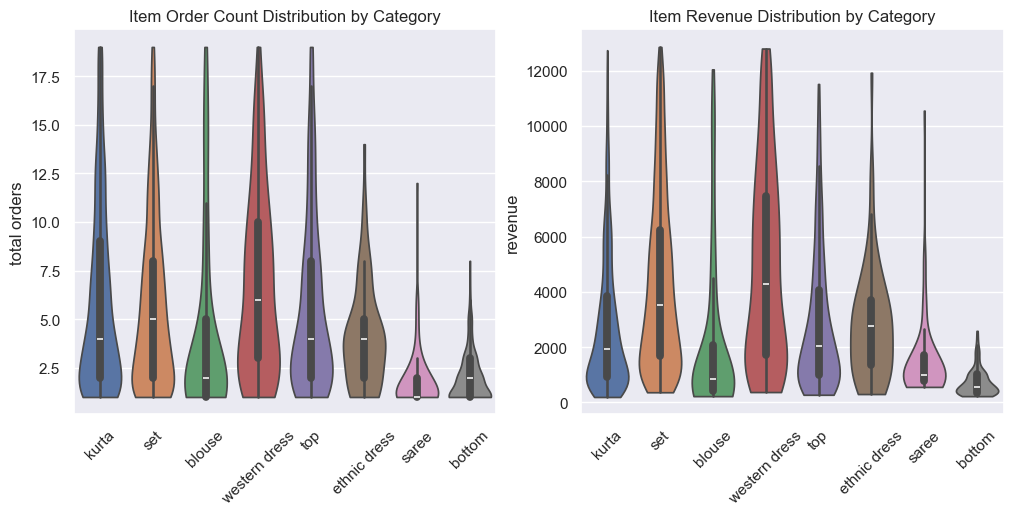

In [19]:
# Plot item order count and revenue distributions by category
plt.subplots(1,2, figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.violinplot(data=sales, y='total_orders', x='category', hue='category', cut=0, inner='box')
plt.title('Item Order Count Distribution by Category')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('total orders')

plt.subplot(1, 2, 2)
sns.violinplot(data=sales, y='revenue', x='category', hue='category', cut=0, inner='box')
plt.title('Item Revenue Distribution by Category')
plt.xticks(rotation=45)
plt.xlabel('')

Note that, in each category, 50% of regular selling items have less than 7 orders over the span of 3 months. This implies 50% of items are low selling, and most revenue and order count is driven by top 50%. This isn't necessarily a bad thing:

- It is possible that having a large variety of items drives consumers to use Amazon more often, leading to better sales for top 50% items. 
- The items might be produced in low numbers and sold over long periods of time, which would synergize with the effect above by increasing item variety.
- It also might indicate that a large variety of vendors are selling through Amazon, regardless of profitability level.

Lets investigate this effect further by looking at data skewness. We'll obtain a 95% confidence intervals for the mean and median of each category

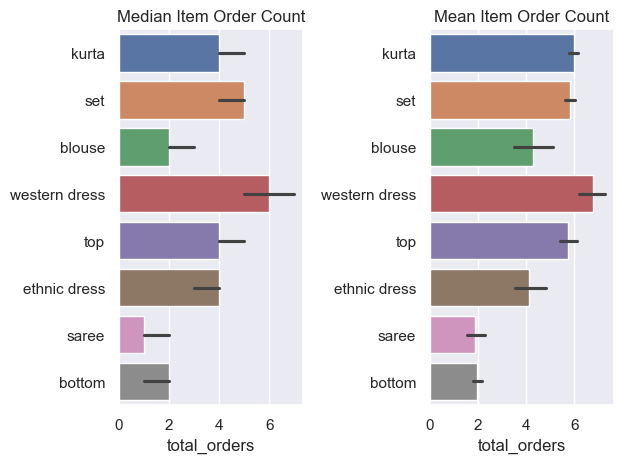

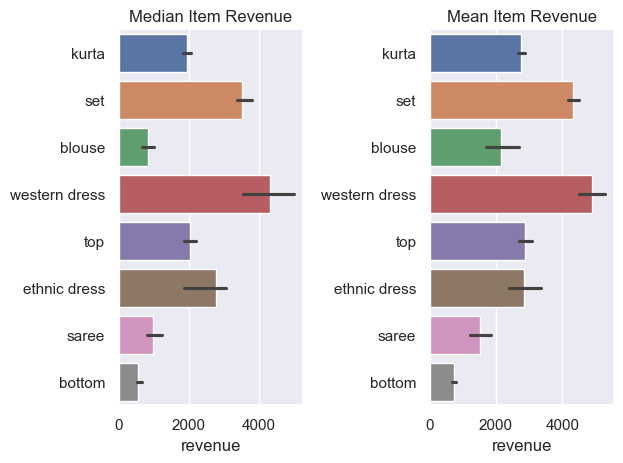

In [20]:
# Plot median and mean order counts
plt.subplot(1, 2, 1)
sns.barplot(data=sales, x='total_orders', y='category', hue='category', estimator=np.median)
plt.title('Median Item Order Count')
plt.ylabel('')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.barplot(data=sales, x='total_orders', y='category', hue='category', estimator=np.mean)
plt.title('Mean Item Order Count')
plt.ylabel('')
plt.tight_layout()
plt.show()


# Plot median and mean item revenue
plt.subplot(1, 2, 1)
sns.barplot(data=sales, x='revenue', y='category', hue='category', estimator=np.median)
plt.title('Median Item Revenue')
plt.ylabel('')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.barplot(data=sales, x='revenue', y='category', hue='category', estimator=np.mean)
plt.title('Mean Item Revenue')
plt.ylabel('')
plt.tight_layout()
plt.show()

Let's investigate price distributions. We'll plot a side by side analysis of order density relative to median unit price and percentage of orders at a discount

C:\Users\husse\AppData\Local\Temp\ipykernel_37800\419513403.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales['discount_percentage'] = sales['orders_at_discount']/sales['total_orders'] * 100


Text(0, 0.5, 'Percentage')

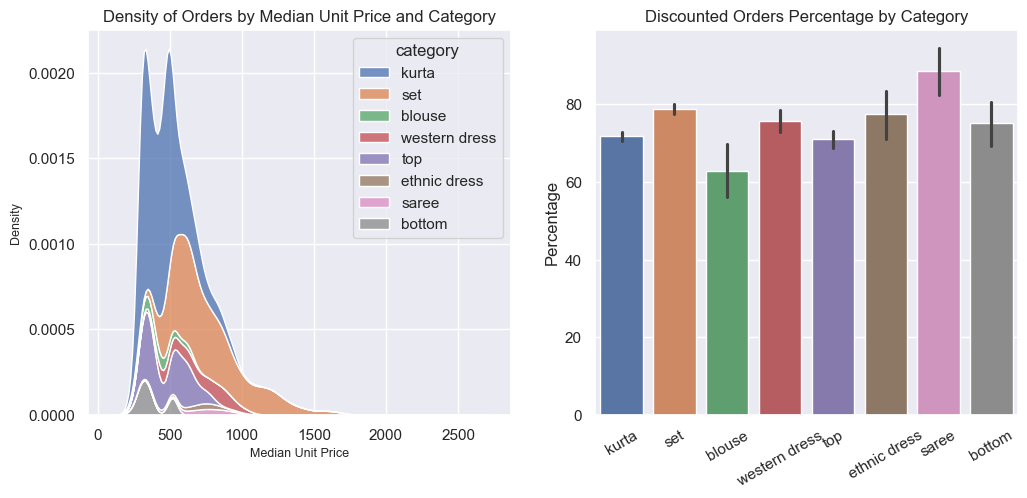

In [21]:

plt.subplots(1, 2, figsize=(12, 5))

# Plot order density relative to median unit price
plt.subplot(1, 2, 1)
sns.kdeplot(data=sales, x='median_unit_price', hue='category', fill=True, multiple='stack', warn_singular=False)
plt.title('Density of Orders by Median Unit Price and Category', fontsize=12)
plt.xlabel('Median Unit Price', fontsize=9)
plt.ylabel('Density', fontsize=9)

# Plot percentage of orders at a discount
plt.subplot(1, 2, 2)
sales['discount_percentage'] = sales['orders_at_discount']/sales['total_orders'] * 100
sns.barplot(data=sales, x='category', y='discount_percentage', hue='category', legend=False)
plt.title('Discounted Orders Percentage by Category')
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('Percentage')

Closer view at each category

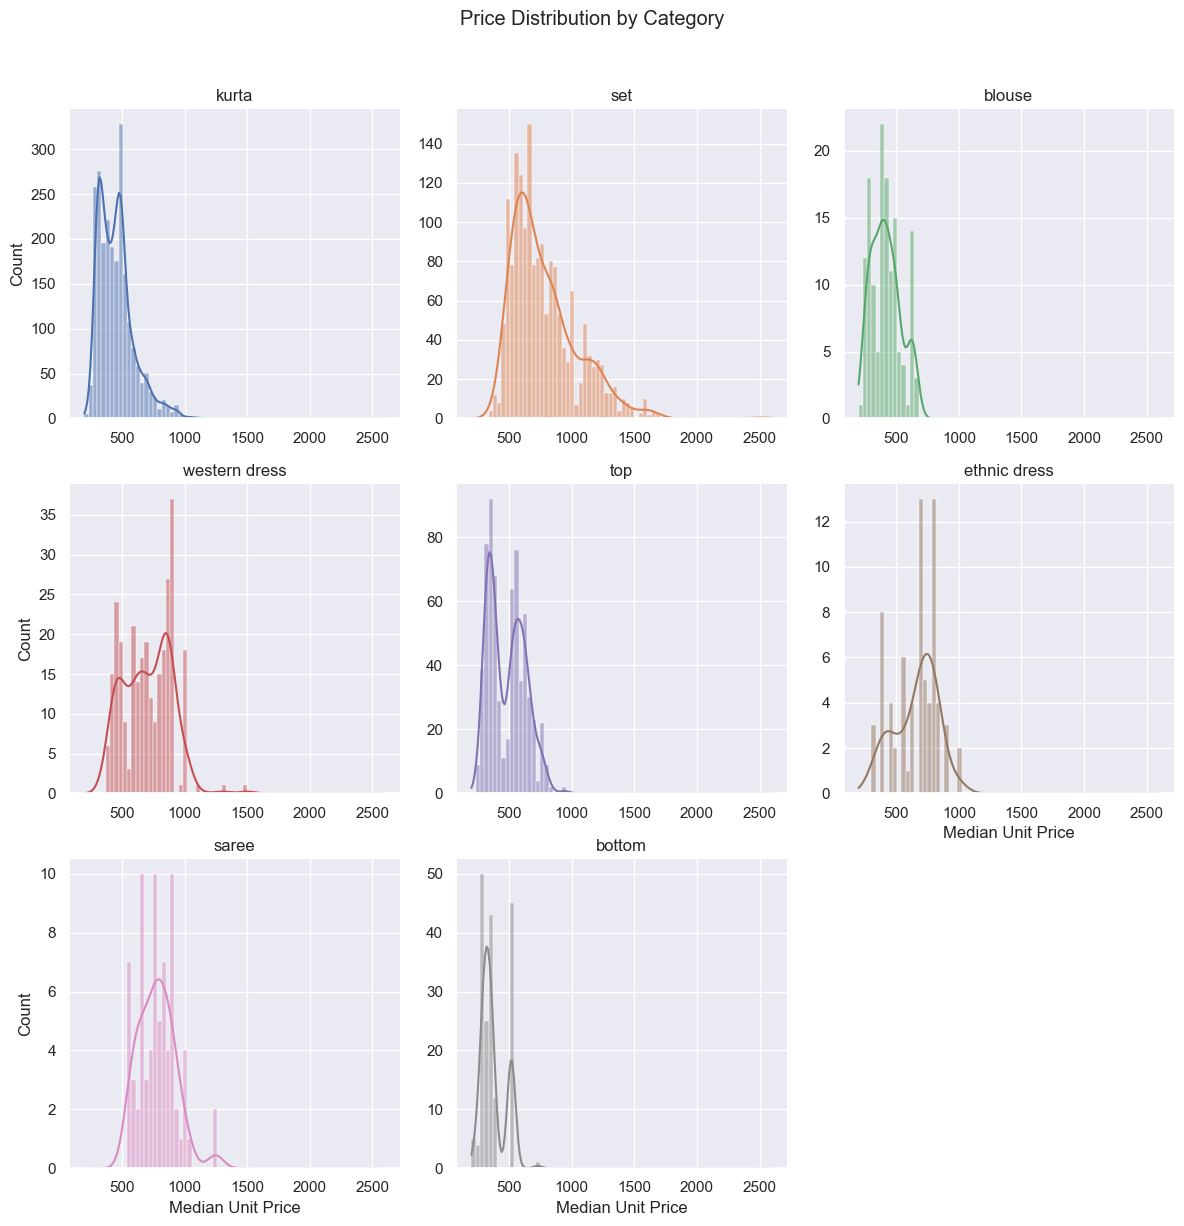

In [22]:
# Plot median unit price distributions per category

g = sns.displot(
    data=sales,
    x='median_unit_price',
    col='category',
    hue='category',
    kde=True,
    col_wrap=3,  
    height=4,
    legend=False,
    facet_kws={'sharex': False, 'sharey': False}
)

g.fig.suptitle('Price Distribution by Category', y=1.02)
g.set_titles("{col_name}")
g.set_axis_labels("Median Unit Price", "Count")
plt.tight_layout()

## Topsellers analysis

Text(0.5, 0, '')

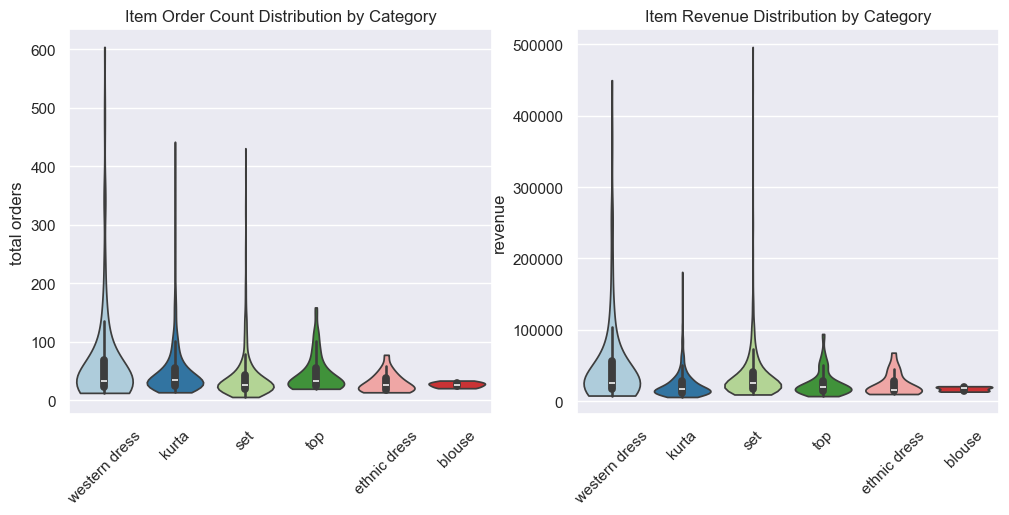

In [23]:
# Plot item order and revenue distributions by category
plt.subplots(1,2, figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.violinplot(data=topsellers, y='total_orders', x='category', hue='category', cut=0, inner='box', palette='Paired')
plt.title('Item Order Count Distribution by Category')
plt.xticks(rotation=45)
plt.xlabel('')
plt.ylabel('total orders')

plt.subplot(1, 2, 2)
sns.violinplot(data=topsellers, y='revenue', x='category', hue='category', cut=0, inner='box', palette='Paired')
plt.title('Item Revenue Distribution by Category')
plt.xticks(rotation=45)
plt.xlabel('')

Western dress, kurta, and set categories have long tail ends. We'll inspect top 20 products in these categories. Are sales heavily influenced by discounts?

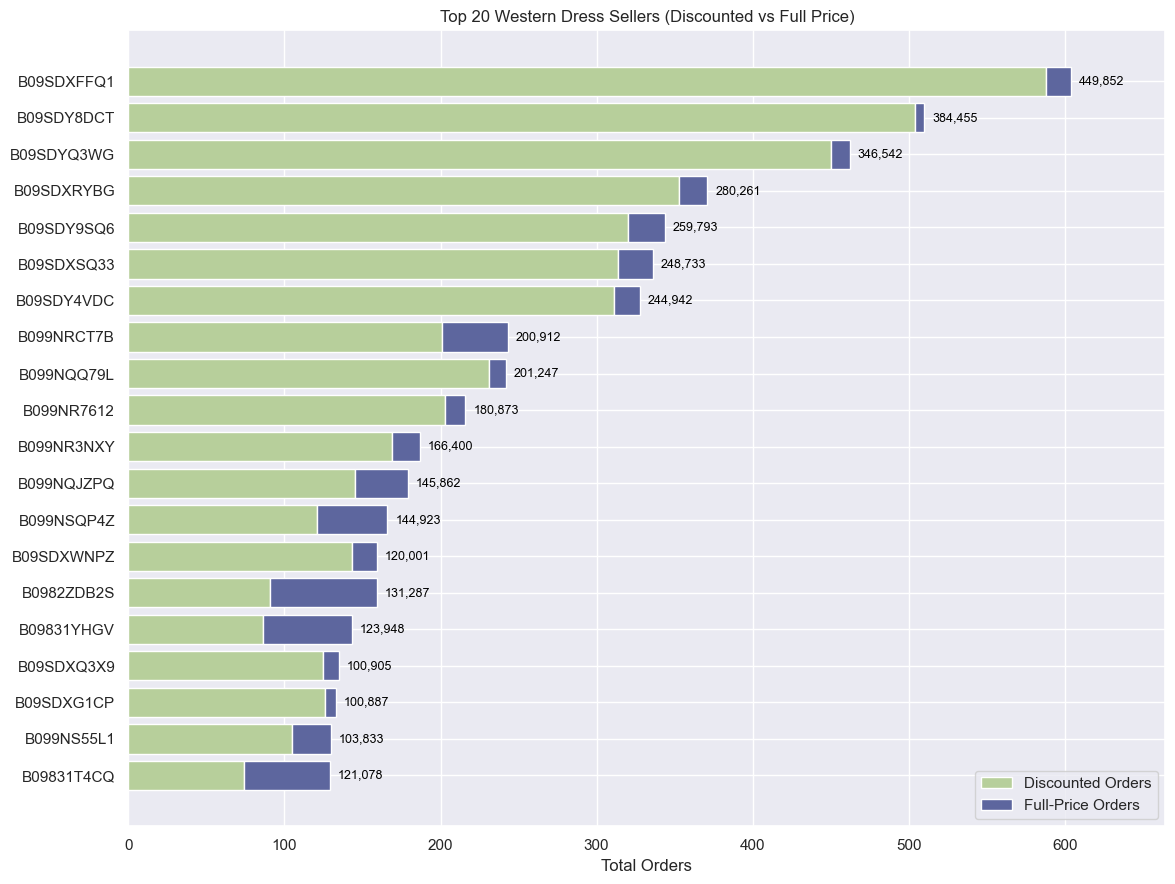

In [24]:
# Plot western dress top 20 sellers
top20_WD= topsellers[topsellers['category']=='western dress'].sort_values('total_orders', ascending=False).iloc[:20].copy()
top20_WD['non_discounted'] = top20_WD['total_orders'] - top20_WD['orders_at_discount']

sns.set_theme()
plt.figure(figsize=(12, 9))
discounted_bars = plt.barh(top20_WD['asin'], top20_WD['orders_at_discount'], 
                 color='#b7cf9b', label='Discounted Orders')
nondiscounted_bars = plt.barh(top20_WD['asin'], top20_WD['non_discounted'], 
                 left=top20_WD['orders_at_discount'], 
                 color='#5d669e', label='Full-Price Orders')

# Add revenue labels
for i, (total, rev) in enumerate(zip(top20_WD['total_orders'], top20_WD['revenue'])):
    label = f"{rev:,.0f}"
    plt.text(total + 5, i, label, va='center', ha='left', fontsize=9, color='black')


plt.xlabel('Total Orders', fontsize=12)
plt.title('Top 20 Western Dress Sellers (Discounted vs Full Price)')
plt.gca().invert_yaxis()
plt.legend(frameon=True)
plt.tight_layout()
max_orders = top20_WD['total_orders'].max()
plt.xlim(0, max_orders * 1.1)

plt.savefig(project_root + '/outputs/figures/top20_WDproducts.png', dpi=300, facecolor='white')
plt.show()

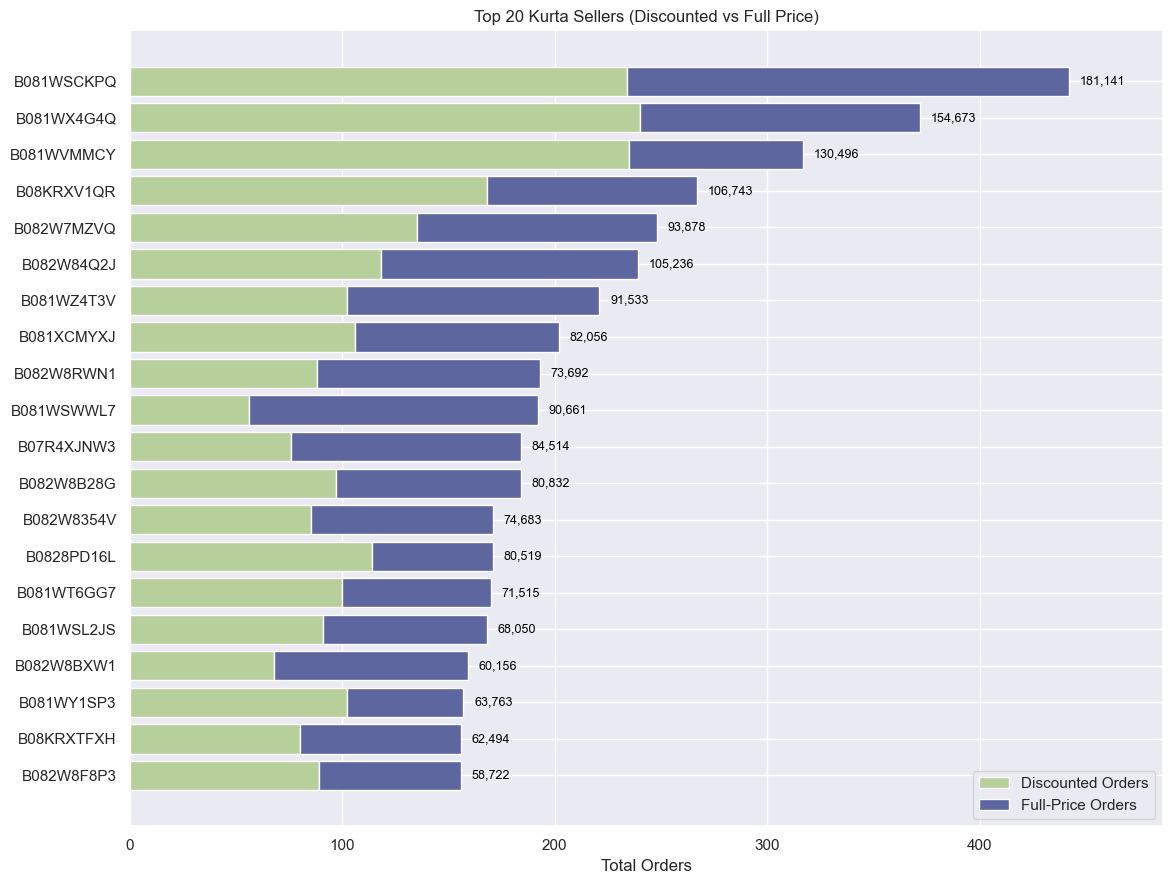

In [25]:
# Plot Kurta top 20 sellers
top20_K= topsellers[topsellers['category']=='kurta'].sort_values('total_orders', ascending=False).iloc[:20].copy()
top20_K['non_discounted'] = top20_K['total_orders'] - top20_K['orders_at_discount']


plt.figure(figsize=(12, 9))
discounted_bars = plt.barh(top20_K['asin'], top20_K['orders_at_discount'], 
                 color='#b7cf9b', label='Discounted Orders')
nondiscounted_bars = plt.barh(top20_K['asin'], top20_K['non_discounted'], 
                 left=top20_K['orders_at_discount'], 
                 color='#5d669e', label='Full-Price Orders')


# Add revenue labels
for i, (total, rev) in enumerate(zip(top20_K['total_orders'], top20_K['revenue'])):
    label = f"{rev:,.0f}"
    plt.text(total + 5, i, label, va='center', ha='left', fontsize=9, color='black')


plt.xlabel('Total Orders', fontsize=12)
plt.title('Top 20 Kurta Sellers (Discounted vs Full Price)')
plt.gca().invert_yaxis()
plt.legend(frameon=True)
plt.tight_layout()
max_orders = top20_K['total_orders'].max()
plt.xlim(0, max_orders * 1.1)

plt.savefig(project_root + '/outputs/figures/top20_Kurta_products.png', dpi=300, facecolor='white')
plt.show()

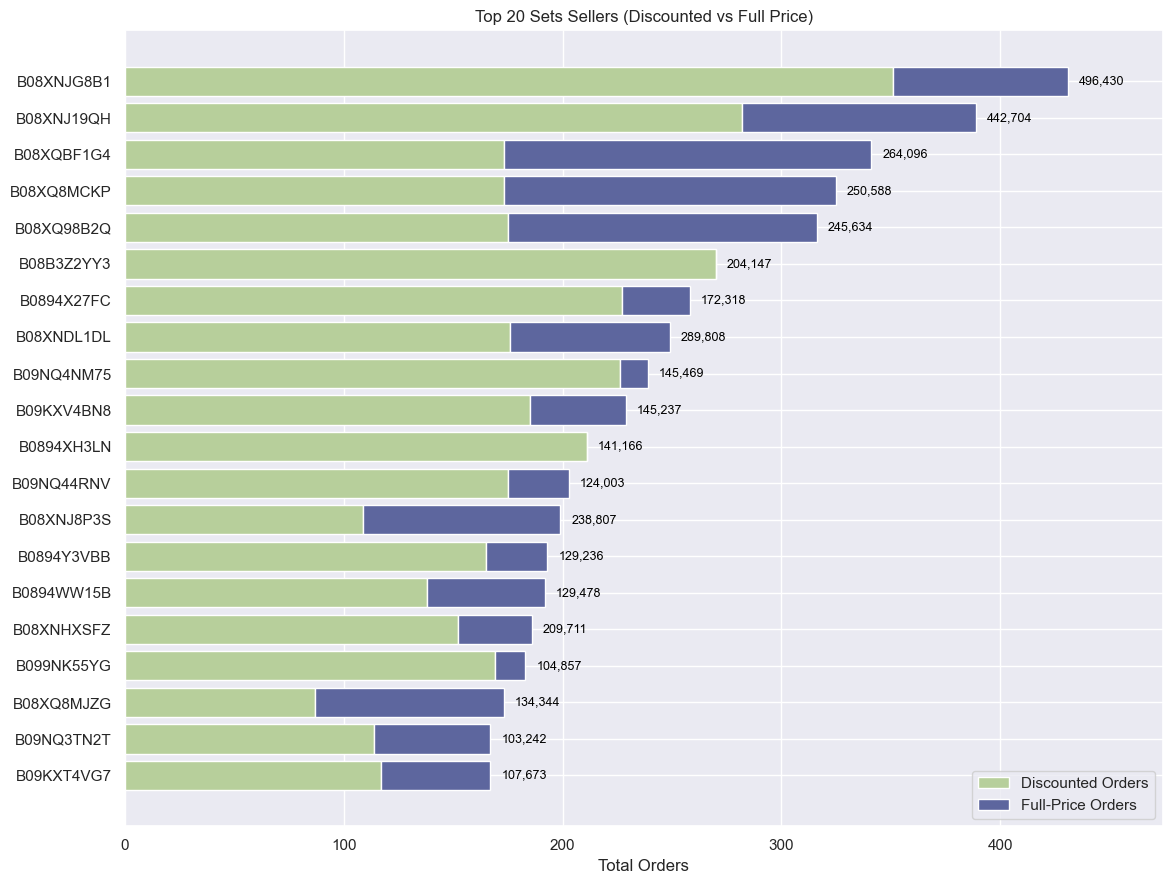

In [26]:
# Plot set top 20 sellers
top20_S= topsellers[topsellers['category']=='set'].sort_values('total_orders', ascending=False).iloc[:20].copy()
top20_S['non_discounted'] = top20_S['total_orders'] - top20_S['orders_at_discount']


plt.figure(figsize=(12, 9))
discounted_bars = plt.barh(top20_S['asin'], top20_S['orders_at_discount'], 
                 color='#b7cf9b', label='Discounted Orders')
nondiscounted_bars = plt.barh(top20_S['asin'], top20_S['non_discounted'], 
                 left=top20_S['orders_at_discount'], 
                 color='#5d669e', label='Full-Price Orders')

# Add revenue labels
for i, (total, rev) in enumerate(zip(top20_S['total_orders'], top20_S['revenue'])):
    label = f"{rev:,.0f}"
    plt.text(total + 5, i, label, va='center', ha='left', fontsize=9, color='black')


plt.xlabel('Total Orders', fontsize=12)
plt.title('Top 20 Sets Sellers (Discounted vs Full Price)')
plt.gca().invert_yaxis()
plt.legend(frameon=True)
plt.tight_layout()
max_orders = top20_S['total_orders'].max()
plt.xlim(0, max_orders * 1.1)

plt.savefig(project_root + '/outputs/figures/top20_Set_products.png', dpi=300, facecolor='white')
plt.show()

Set and kurta topsellers have fewer total orders but are less discounted than western dress topsellers. This suggests that western dress items may be more price elastic, leading to higher sales when discounted. Let's look at 
price distributions and discount percentages.

C:\Users\husse\AppData\Local\Temp\ipykernel_37800\3311062120.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topsellers['discount_percentage'] = topsellers['orders_at_discount']/topsellers['total_orders'] * 100


Text(0, 0.5, 'Percentage')

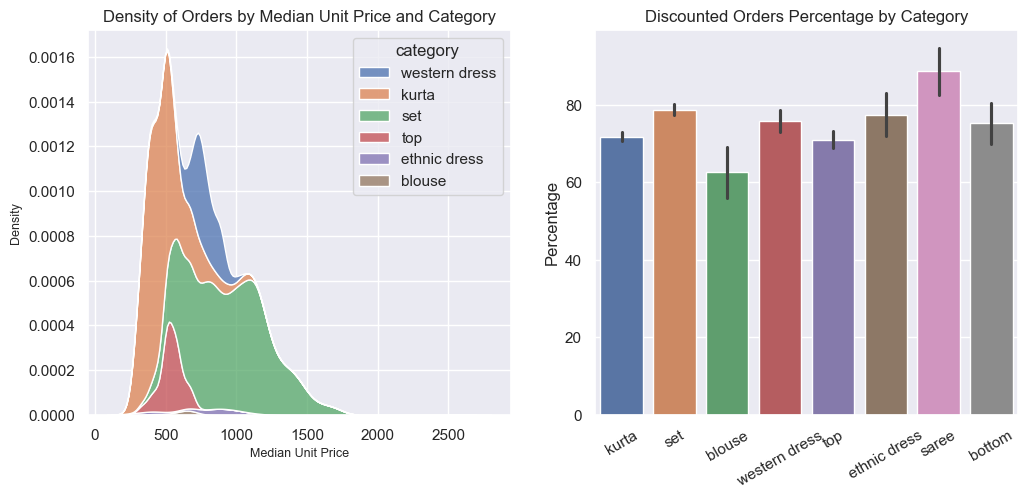

In [27]:
plt.subplots(1, 2, figsize=(12, 5))

# Plot topseller order density relative to median unit price
plt.subplot(1, 2, 1)
sns.kdeplot(data=topsellers, x='median_unit_price', hue='category', fill=True, multiple='stack')
plt.title('Density of Orders by Median Unit Price and Category', fontsize=12)
plt.xlabel('Median Unit Price', fontsize=9)
plt.ylabel('Density', fontsize=9)

# Plot percentage of orders at a discount
plt.subplot(1, 2, 2)
topsellers['discount_percentage'] = topsellers['orders_at_discount']/topsellers['total_orders'] * 100
sns.barplot(data=sales, x='category', y='discount_percentage', hue='category', legend=False)
plt.title('Discounted Orders Percentage by Category')
plt.xticks(rotation=30)
plt.xlabel('')
plt.ylabel('Percentage')

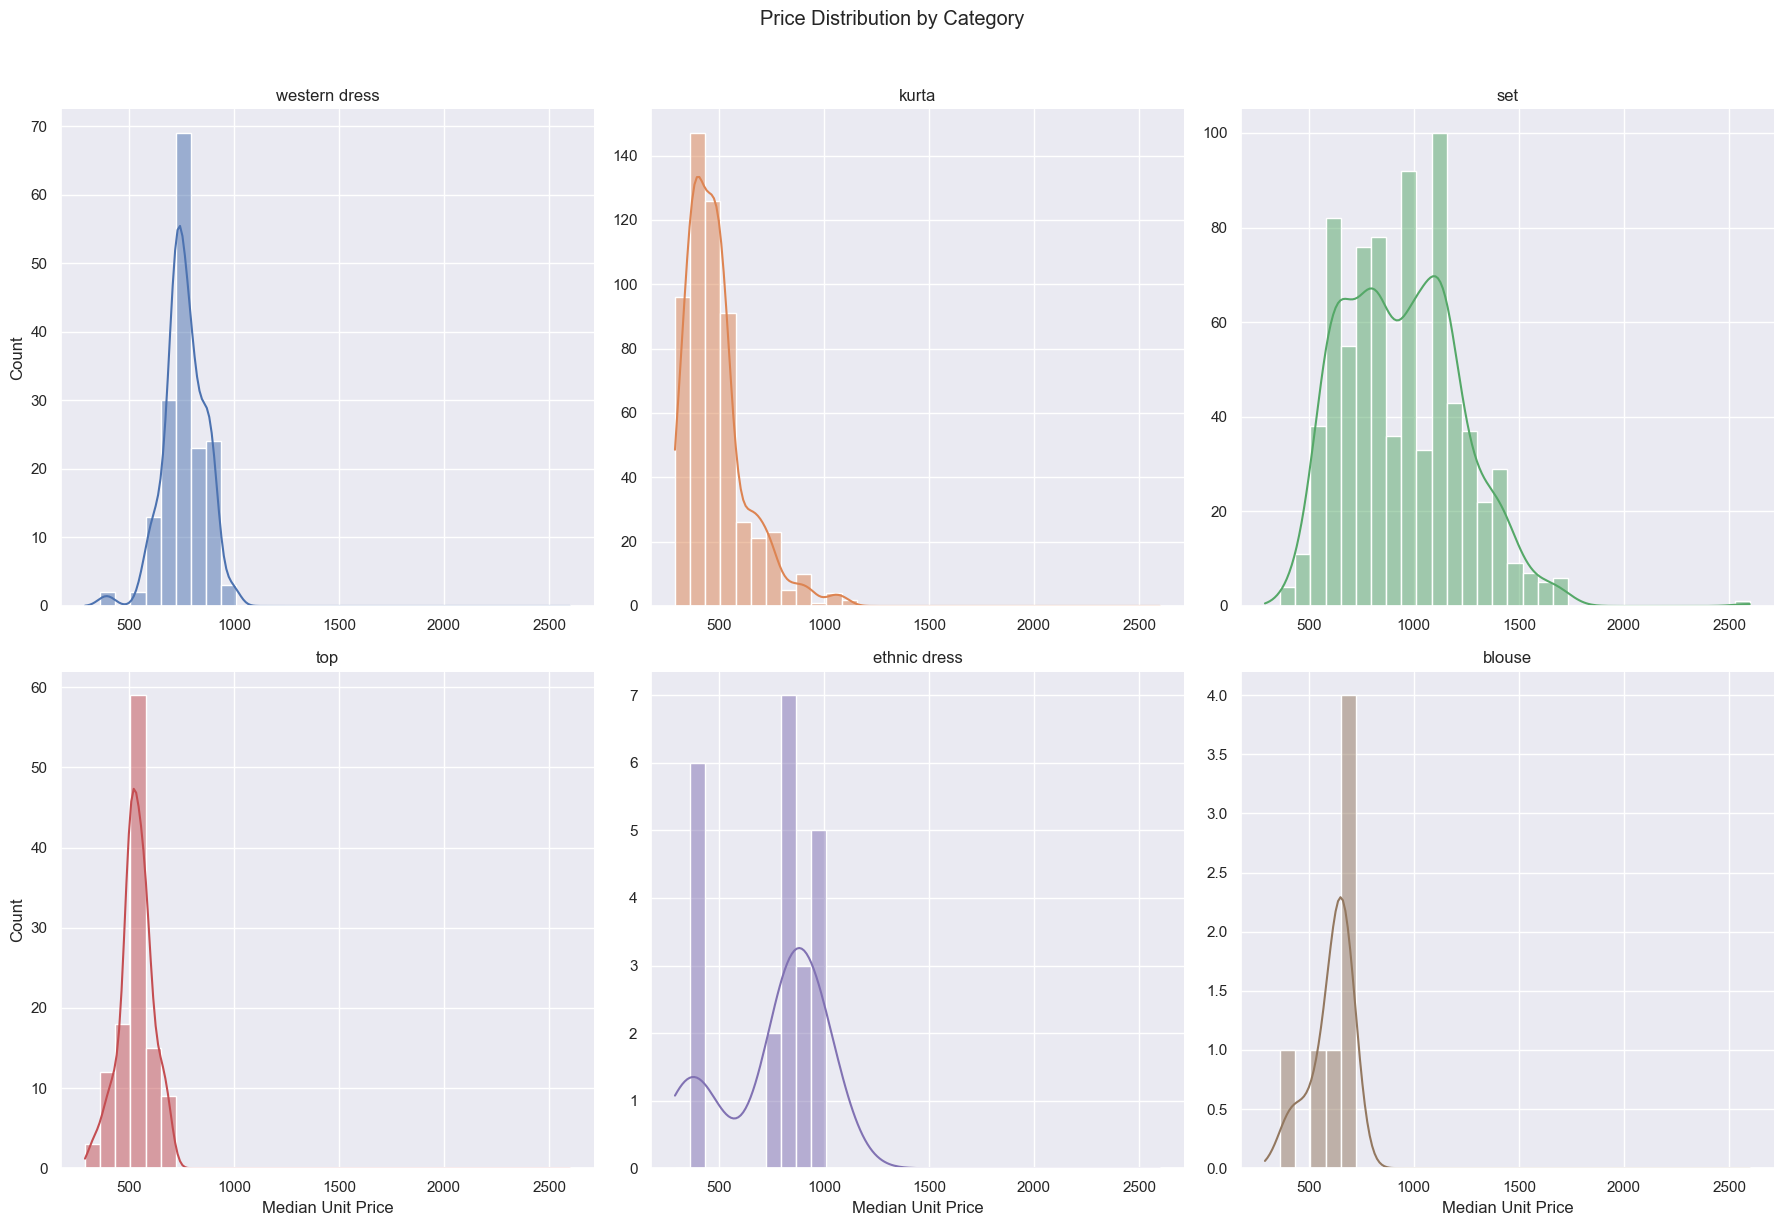

In [28]:
# Plot topseller median unit price distributions
g = sns.displot(
    data=topsellers,
    x='median_unit_price',
    col='category',
    hue='category',
    kde=True,
    col_wrap=3,  
    height=6,
    legend=False,
    facet_kws={'sharex': False, 'sharey': False}
)

g.fig.suptitle('Price Distribution by Category', y=1.02)
g.set_titles("{col_name}")
g.set_axis_labels("Median Unit Price", "Count")

plt.tight_layout()


Let's examine aggregates by category of topsellers vs regular sales.

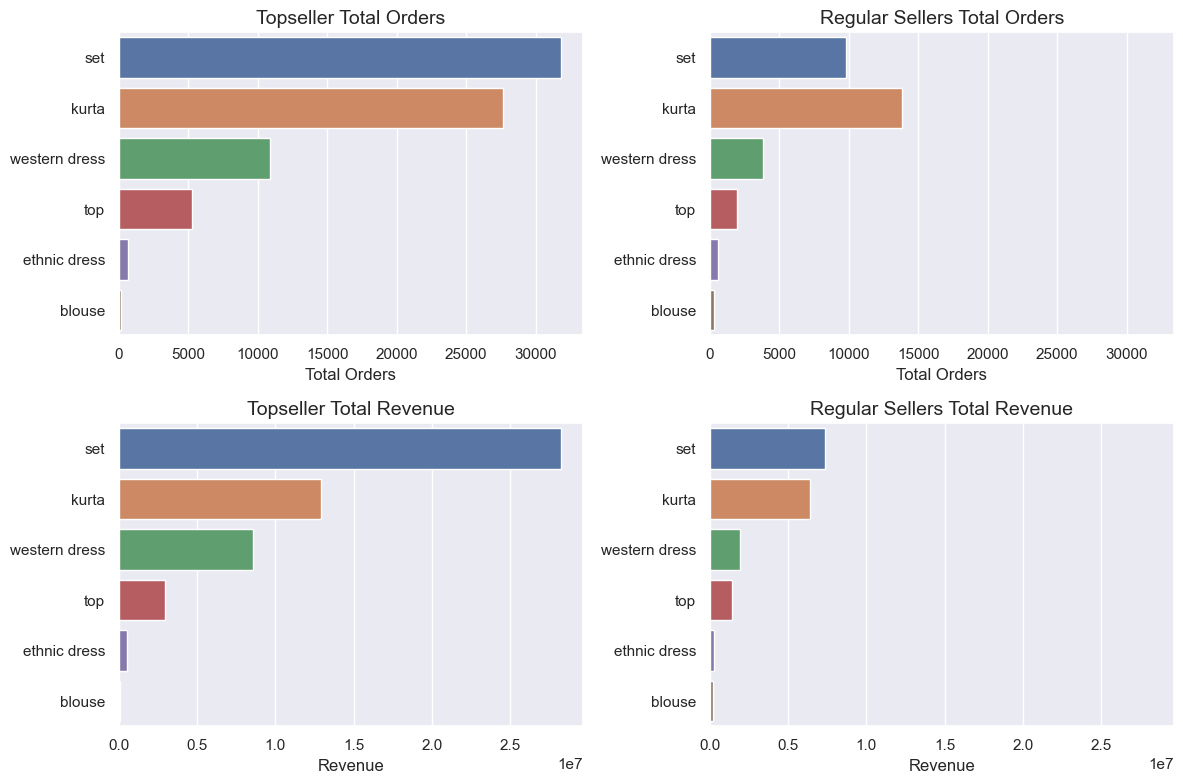

In [29]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot topsellers aggregates
aggregates = topsellers.groupby('category').agg({'total_orders': 'sum', 'revenue': 'sum'}).reset_index().sort_values(by='revenue', ascending=False)

sns.barplot(data=aggregates, x='total_orders', y='category', hue='category', ax=ax1)
ax1.set_xlabel('Total Orders', fontsize=12)
ax1.set_ylabel('')
ax1.set_title('Topseller Total Orders', fontsize=14)

sns.barplot(data=aggregates, x='revenue', y='category', hue='category', ax=ax3)
ax3.set_xlabel('Revenue', fontsize=12)
ax3.set_ylabel('')
ax3.set_title('Topseller Total Revenue', fontsize=14)


# Plot regular sellers aggregates
aggregates_r = sales.groupby('category').agg({'total_orders': 'sum', 'revenue': 'sum'}).reset_index().sort_values(by='revenue', ascending=False)

sns.barplot(data=aggregates_r, x='total_orders', y='category', hue='category', ax=ax2)
ax2.set_xlabel('Total Orders', fontsize=12)
ax2.set_ylabel('')
ax2.set_title('Regular Sellers Total Orders', fontsize=14)
ax2.sharey(ax1)
ax2.set_xlim(ax1.get_xlim())

sns.barplot(data=aggregates_r, x='revenue', y='category', hue='category', ax=ax4)
ax4.set_xlabel('Revenue', fontsize=12)
ax4.set_ylabel('')
ax4.set_title('Regular Sellers Total Revenue', fontsize=14)
ax4.sharey(ax3)
ax4.set_xlim(ax3.get_xlim())

plt.tight_layout()

Note for regular selling items, kurta category has the highest order count and is about half the number of orders in the topselling kurta category. This can't be explained by price levels because the price distributions do not significantly differ between top and regular selling kurtas. This may indicate there is demand for variety in this category since less demand is concetrated in topselling items.

# Cancellation Pattern Analysis

Is there a relationship between any significant features and order cancellations?

In [30]:
cancellations = dataframes['orders'].copy()
cancellations.replace({'category': 'dupatta'}, {'category': 'ethnic dress'}, inplace=True)
cancellations['is_cancelled'] = cancellations['status'] == 'cancelled or returned'

# Display cancellation percentages vs categorical features
categorical_cols = ['category', 'size', 'sales_channel', 'ship_service_level', 
                    'fulfillment', 'style', 'b2b', 'ship_state_or_territory']

cancel_percentage = {}

for col in categorical_cols:
    cat_cancelled = cancellations.groupby(col)['is_cancelled'].sum()
    cat_totals = cancellations.groupby(col)['index_id'].count()
    cancel_percentage[col] = (cat_cancelled/cat_totals).sort_values(ascending=False) * 100

for k, v in cancel_percentage.items():
    print(f"{v}\n")

category
set              17.168944
western dress    17.059165
kurta            16.842570
bottom           14.651163
ethnic dress     14.482759
blouse           14.332248
top              14.003202
saree            12.345679
dtype: float64

size
XS      19.072812
S       17.681499
M       17.576318
L       16.668928
XL      16.249760
XXL     15.715550
3XL     14.966583
FREE    14.666667
5XL     13.090909
4XL     12.880562
6XL     11.397558
dtype: float64

sales_channel
non-amazon    100.000000
amazon.in      16.635478
dtype: float64

ship_service_level
standard     23.935418
expedited    13.420788
dtype: float64

fulfillment
easy ship    24.165775
amazon       13.444591
dtype: float64

style
SET235     100.000000
BL075      100.000000
SAR166     100.000000
AN210      100.000000
SAR037      66.666667
              ...    
J0121        0.000000
J0116        0.000000
J0115        0.000000
JNE3736      0.000000
CH206        0.000000
Length: 1372, dtype: float64

b2b
f    16.755579
t     9.

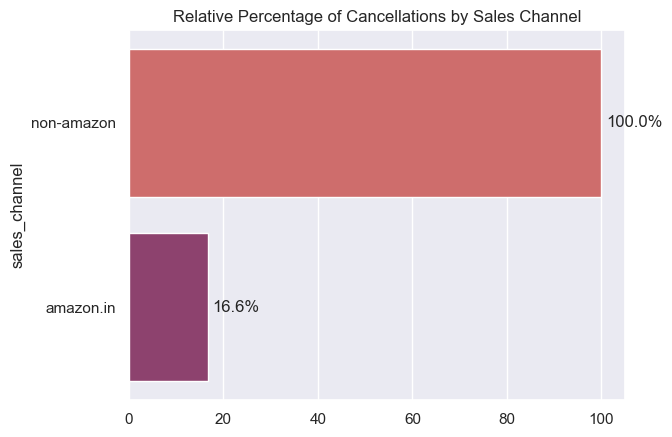

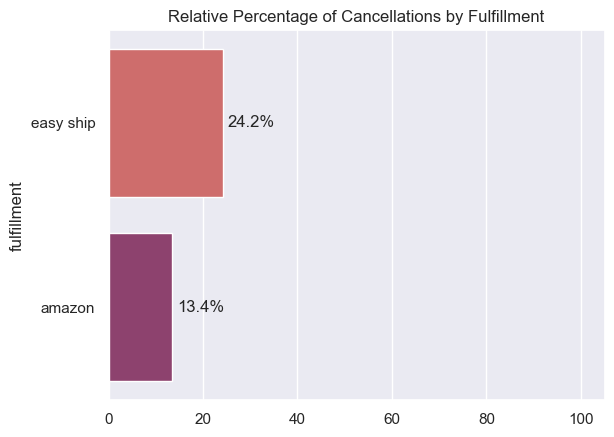

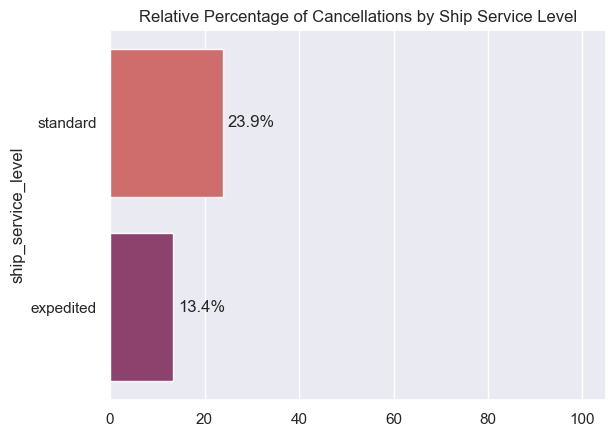

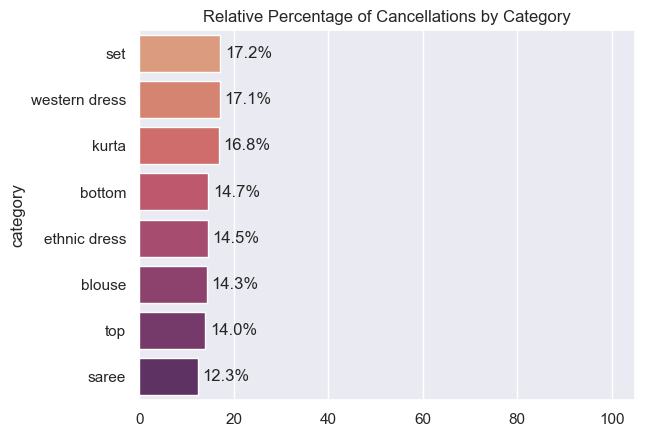

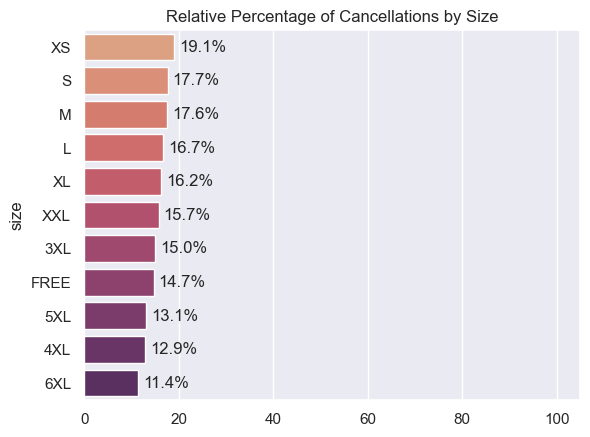

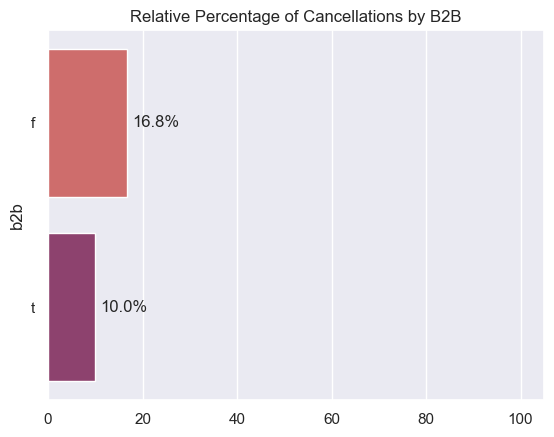

In [31]:
# Plot cancellation percentages for categorical columns with few unique values
for cat in ['sales_channel', 'fulfillment', 'ship_service_level', 'category', 'size', 'b2b']:
    ax = sns.barplot(
        x=cancel_percentage[cat].values, 
        y=cancel_percentage[cat].index, 
        hue=cancel_percentage[cat].index, 
        palette='flare'
    )
    
    # Add percentage labels to the bars
    for i, v in enumerate(cancel_percentage[cat].values):
        ax.text(
            v + 1,
            i,
            f'{v:.1f}%',
            va='center',
        )
    
    plt.title(f"Relative Percentage of Cancellations by {cat.replace('_', ' ').title()}")
    plt.xlim(0, 105)
    plt.show()

- 100% of non-amazon sales were cancelled. These orders might be fradulent, we'll investigate after looking at cancellation patterns
- Orders fulfilled by easy ship are about twice as likely to be cancelled. Indicates likely poor shipping service
- Expedieted shipping orders half as likely to get cancelled, which is expected. 
- Cancellation percentages closely follow order patterns. This is likely because items with higher demands are more scrutinized by buyers. 
- Smaller sizing correlates with higher cancellation percentages in a semi linear fashion. This is likely due to vanity sizing choices by consumers.
- Business-to-business orders are about 7% less likely to get cancelled. 

Next, we'll look at cancellations relative to order total amount and ship state or territory

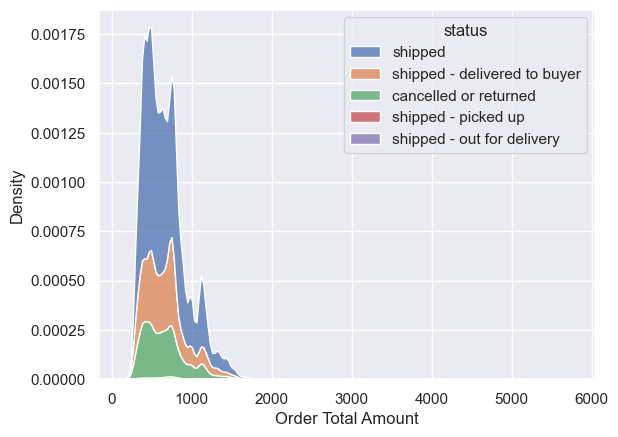

In [32]:
# Plot order total amount distributions by status
sns.kdeplot(dataframes['orders'], x='amount', hue='status', fill=True, multiple='stack')
plt.xlabel('Order Total Amount')
plt.show()

Looks like no significant correlation between order total and cancellation behavior. Let's double check for linear correlation. 

In [33]:
# Display correlation matrix for cancellations vs amount and quantity
cancellations[['amount', 'quantity', 'is_cancelled']].corr()

,amount,quantity,is_cancelled
amount,1.000000,0.163126,-0.014191
quantity,0.163126,1.000000,0.009661
is_cancelled,-0.014191,0.009661,1.000000


No significant linear coorelation between cancellations and amount/quantity. Next, let's look at cancellation patterns relative to state or territory.

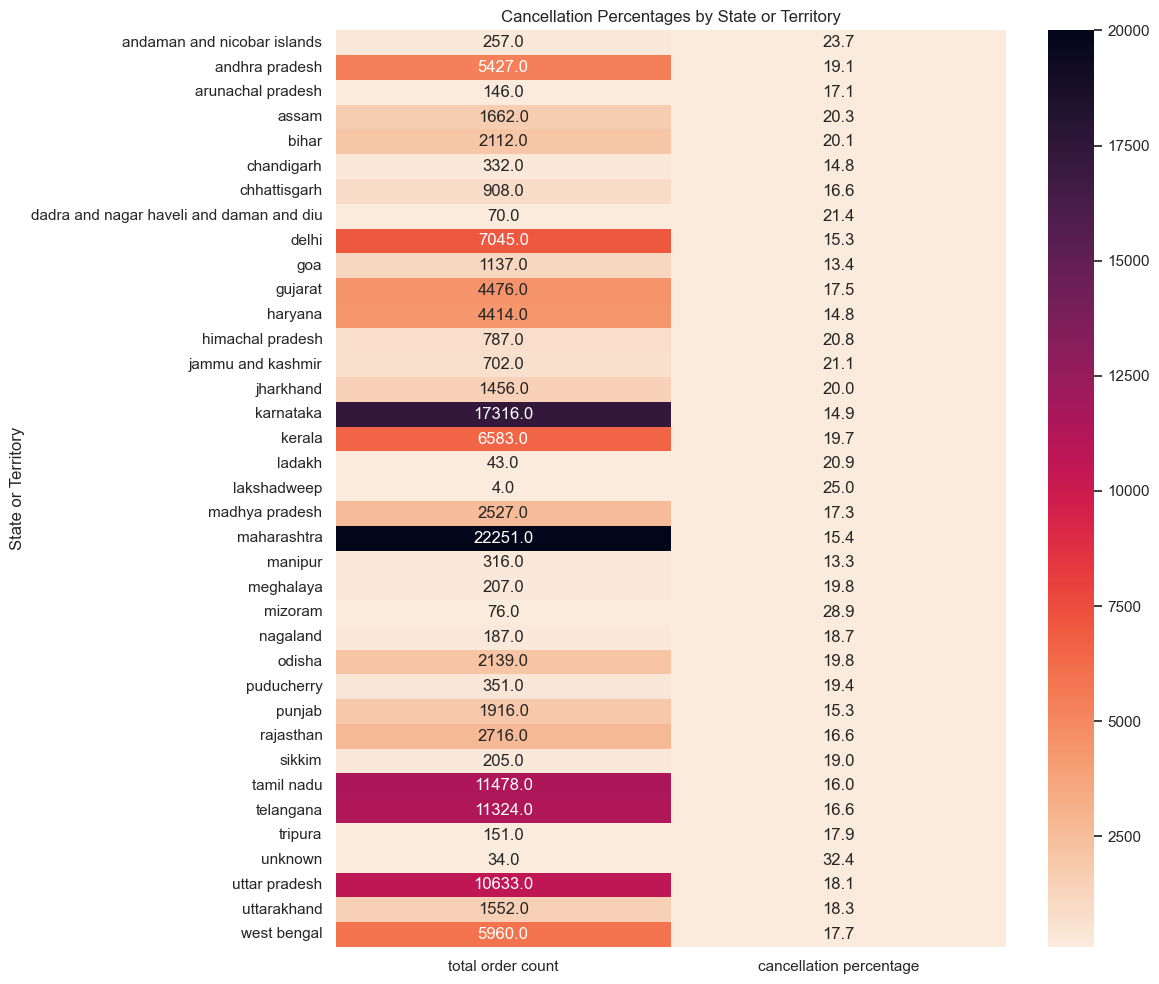

In [34]:
# Plot cancellation percentages by ship state or territory
pivot = cancellations.pivot_table(
    values=['is_cancelled', 'index_id'],
    index='ship_state_or_territory',
    aggfunc=
    {'is_cancelled' : 'mean',
    'index_id' : 'count'},
)
pivot['is_cancelled'] = pivot['is_cancelled'] * 100
pivot.columns = ['total order count', 'cancellation percentage']

plt.figure(figsize=(12, 10))
sns.heatmap(pivot, cmap='rocket_r', vmin=100, vmax=20000, annot=True, fmt=".1f")
plt.title('Cancellation Percentages by State or Territory')
plt.ylabel('State or Territory')
plt.tight_layout()
plt.show()

Cancellations in states/territories with high order count fall between 15%-20%. Let's look at time analysis of cancellation patterns.

<Axes: xlabel='date', ylabel='Density'>

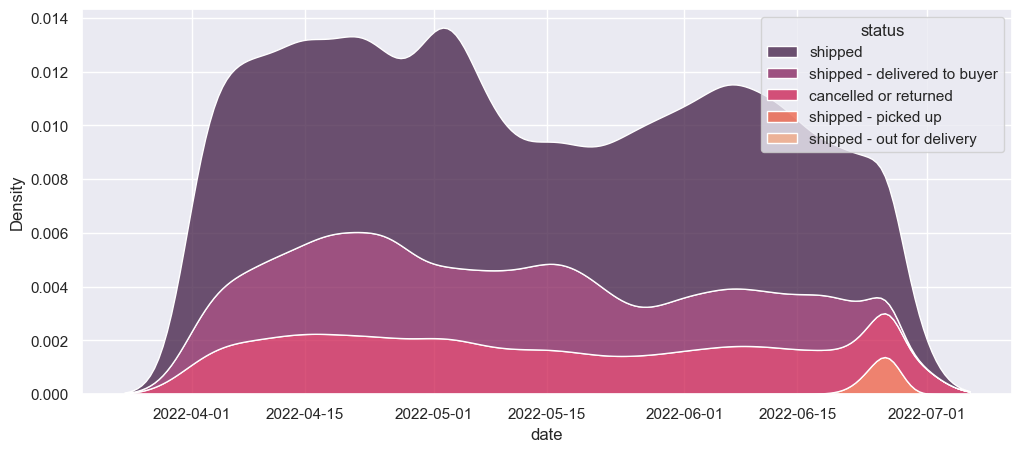

In [35]:
# Let's check time analysis
dataframes['orders']['date'] = pd.to_datetime(dataframes['orders']['date'])
plt.figure(figsize=(12, 5))
sns.kdeplot(data=dataframes['orders'], x='date', hue='status', fill=True, multiple='stack', palette='rocket')

No significant correlation, but cancellation rate is lowest between May and June.

# Regional Demand Analysis

We'll start with some feature engineering for top 10 states/territories. 

In [36]:
# Display regional sales data and separate top 10 states/territories
display(dataframes['regional_sales'])

top_regions = dataframes['regional_sales'].head(10)['ship_state_or_territory'].tolist()
print(f"Top states/territories:")
display(top_regions)

,ship_state_or_territory,total_orders,cancelled_orders,completed_orders,unique_orders,units_sold
0,maharashtra,22251,3419,18832,20774,18880
1,karnataka,17316,2576,14740,16173,14792
2,tamil nadu,11478,1837,9641,10515,9699
3,telangana,11324,1883,9441,10399,9481
4,uttar pradesh,10633,1923,8710,10058,8746
5,delhi,7045,1075,5970,6606,5981
6,kerala,6583,1299,5284,6105,5300
7,west bengal,5960,1053,4907,5651,4923
8,andhra pradesh,5427,1034,4393,4977,4414
9,gujarat,4476,785,3691,4157,3699


Top states/territories:


['maharashtra',
 'karnataka',
 'tamil nadu',
 'telangana',
 'uttar pradesh',
 'delhi',
 'kerala',
 'west bengal',
 'andhra pradesh',
 'gujarat']

In [37]:
# Separate and display top regions item sales
dataframes['regional_demand'] = dataframes['regional_demand'].replace({'category': 'dupatta'}, {'category': 'ethnic dress'})
top_regions_item_sales = dataframes['regional_demand'][dataframes['regional_demand']['ship_state_or_territory'].isin(top_regions)]
display(top_regions_item_sales.head(10))

,asin,ship_state_or_territory,category,regional_orders,rank
0,B09SDXFFQ1,karnataka,western dress,124,1
1,B09SDY8DCT,kerala,western dress,114,1
2,B09SDXFFQ1,maharashtra,western dress,112,2
3,B09SDXFFQ1,kerala,western dress,102,3
4,B08XNJG8B1,maharashtra,set,95,1
5,B09SDYQ3WG,kerala,western dress,94,1
6,B09SDY4VDC,maharashtra,western dress,93,1
7,B08XQ98B2Q,maharashtra,set,91,1
8,B081WX4G4Q,maharashtra,kurta,89,1
9,B09SDYQ3WG,maharashtra,western dress,88,2


In [38]:
# Sum orders by region and category and display
region_top_categories = top_regions_item_sales.groupby(['ship_state_or_territory', 'category']).agg({'regional_orders': 'sum'}).reset_index()


region_top_categories.sort_values(by=['ship_state_or_territory', 'regional_orders'], ascending=False, inplace=True)
region_top_categories.reset_index(drop=True, inplace=True)
display(region_top_categories.head(16))

,ship_state_or_territory,category,regional_orders
0,west bengal,kurta,2569
1,west bengal,set,2107
2,west bengal,western dress,614
3,west bengal,top,549
4,west bengal,ethnic dress,48
5,west bengal,blouse,37
6,west bengal,bottom,25
7,west bengal,saree,11
8,uttar pradesh,set,5152
9,uttar pradesh,kurta,3453


Let's begin analysis. We'll start by plotting order count by category and state/territory.

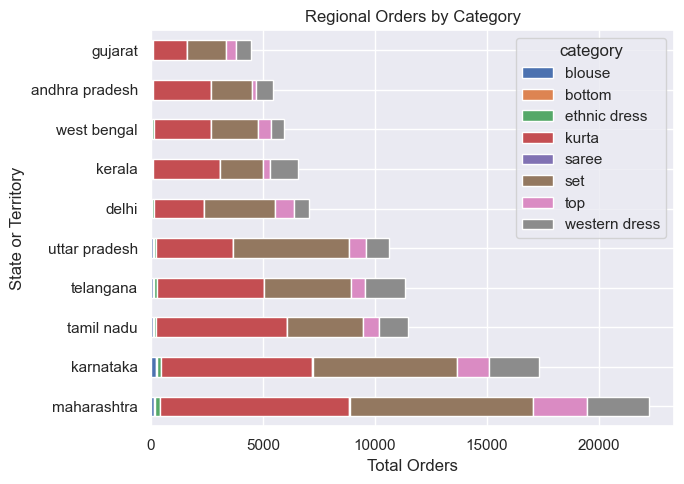

In [39]:
# Pivot data to region vs category and plot
pivot = region_top_categories.pivot_table(
    index='ship_state_or_territory',
    columns='category',
    values='regional_orders'
)

# Plot regional orders by category
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]
pivot.plot(kind='barh', stacked=True, figsize=(7, 5))
plt.title("Regional Orders by Category")
plt.xlabel("Total Orders")
plt.ylabel("State or Territory")
plt.tight_layout()
plt.show()

Distributions of order count by category are highly similar. Let's rescale to percentages to analyze differences in category preferences.
- Step 1: look at percentage of orders by region of each category.
- Step 2: plot deviations

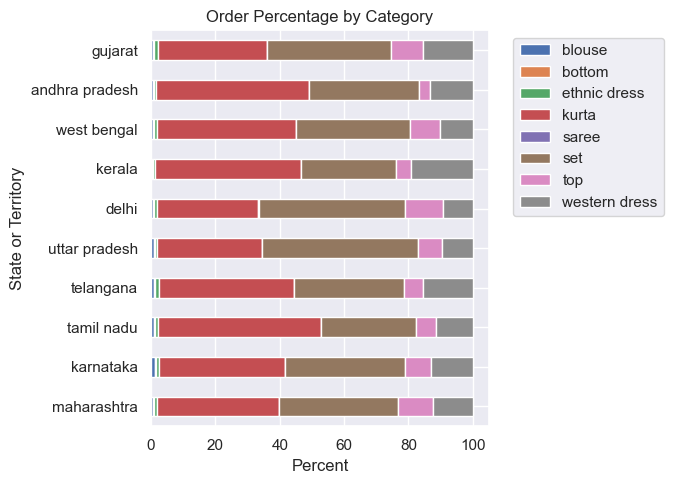

In [40]:
# Plot regional order percentages by category
category_order_percentages = pivot
total_orders = pivot.sum(axis=1)
for col in pivot:
    category_order_percentages[col] = category_order_percentages[col]/total_orders * 100

category_order_percentages.plot(kind='barh', stacked=True, figsize=(7,5))
plt.title("Order Percentage by Category")
plt.xlabel("Percent")
plt.ylabel("State or Territory")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Consistent pattern for all regions: most orders are for kurta and set products. About a fifth of sales are for western dress products. 

Next, let's look at cancellation percentages for top categories and regions.

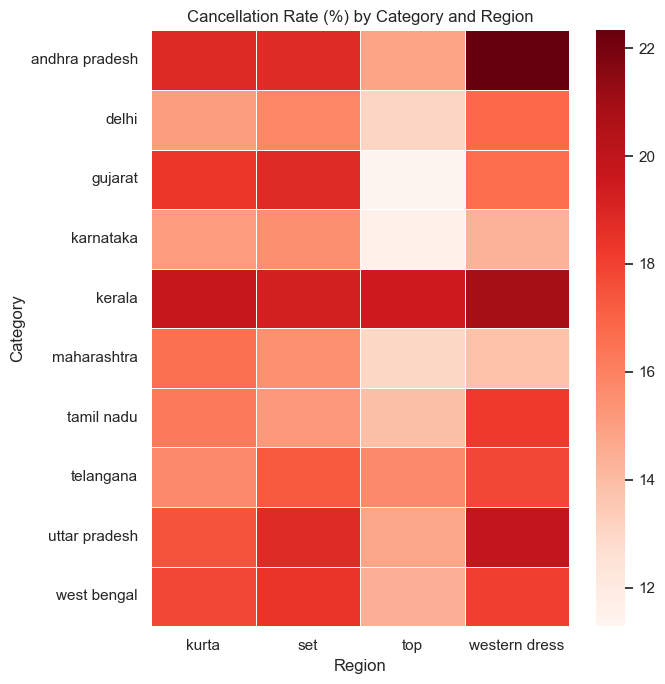

In [41]:
# Plot cancellation rates heat map by region and category
top_categories = ['set', 'kurta', 'top', 'western dress']

grouped = cancellations[
    (cancellations['ship_state_or_territory'].isin(top_regions)) & 
    (cancellations['category'].isin(top_categories))
].groupby(['ship_state_or_territory', 'category']).agg(
    total_orders=('index_id', 'count'),
    cancellations=('is_cancelled', 'sum')
).reset_index()
grouped['cancel_rate'] = grouped['cancellations'] / grouped['total_orders']

pivot = grouped.pivot_table(
    index='ship_state_or_territory',
    columns= 'category',
    values='cancel_rate'
)

plt.figure(figsize=(7, 7))
sns.heatmap(pivot * 100, cmap='Reds', annot=False, fmt=".1f", linewidths=0.5)
plt.title("Cancellation Rate (%) by Category and Region")
plt.ylabel("Category")
plt.xlabel("Region")
plt.tight_layout()
plt.show()

Kerala and Andhra Pradesh have high cancellation percentages. Let's take a closer look by analyzing deviation patterns

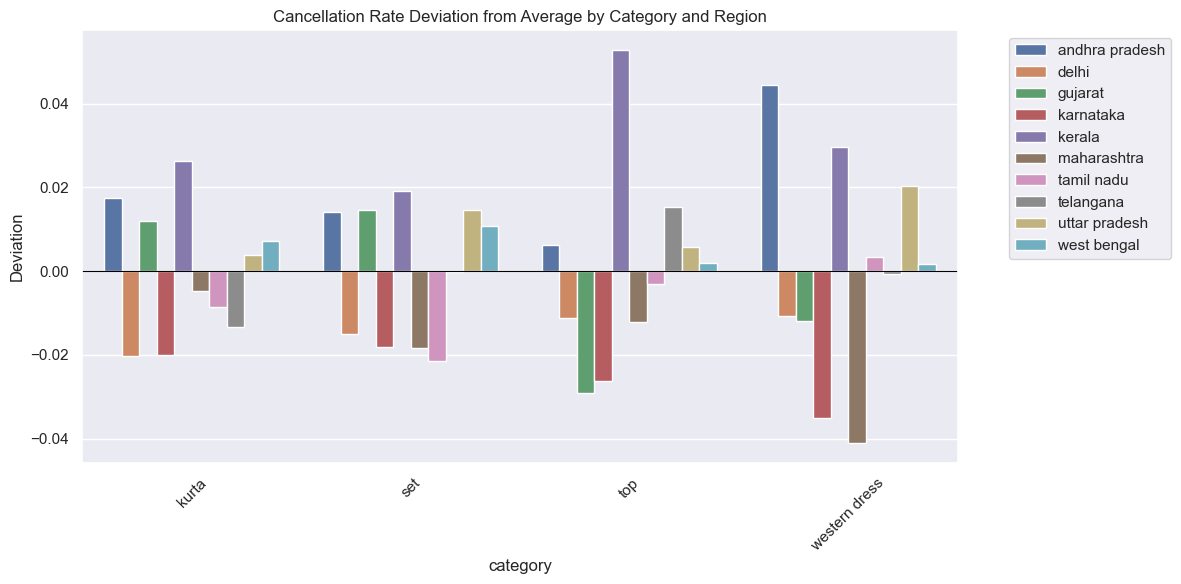

In [42]:
# Compute category average cancellation rates.
global_avg = grouped.groupby('category')['cancel_rate'].mean()

# Calculate deviation and plot
grouped['cancel_diff'] = grouped.apply(
    lambda x: x['cancel_rate'] - global_avg[x['category']], axis=1
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped,
    x='category',
    y='cancel_diff',
    hue='ship_state_or_territory',
    palette='deep'
)
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Cancellation Rate Deviation from Average by Category and Region")
plt.ylabel("Deviation")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()